# Training and testing using the CNN

In [26]:
import nltk
import numpy as np
import pandas as pd
import re
import warnings
warnings.filterwarnings("ignore")
import ftfy
import matplotlib.pyplot as plt
from math import exp
from numpy import sign
from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from nltk import PorterStemmer
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

declaring the constant

In [25]:
TRAIN_SPLIT = 0.6
np.random.seed(1234) 
TEST_SPLIT = 0.2
LEARNING_RATE = 0.1
MAX_NB_WORDS = 18000
EPOCHS= 5
MAX_SEQUENCE_LENGTH = 140 
EMBEDDING_DIM = 300

### Laoding the dataset

In [3]:
DEPRESSIVE_TWEETS_CSV = 'depressive_tweets_processed.csv'
RANDOM_TWEETS_CSV = 'tweetdata1.csv'
EMBEDDING_FILE = 'GoogleNews-vectors-negative300.bin.gz'

In [27]:
depressive_tweets_df = pd.read_csv(DEPRESSIVE_TWEETS_CSV, sep = '|', header = None, usecols = range(0,9), nrows = 3200 )

random_tweets_df = pd.read_csv(RANDOM_TWEETS_CSV, encoding = "ISO-8859-1", usecols = range(0,6), nrows =12000)

#this is a word to vector vocal

In [5]:
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [28]:
depressive_tweets_df.head()

,0,1,2,3,4,5,6,7,8
0,989292962323615744,2018-04-25,23:59:57,Eastern Standard Time,whosalli,The lack of this understanding is a small but ...,1,0,3
1,989292959844663296,2018-04-25,23:59:56,Eastern Standard Time,estermnunes,i just told my parents about my depression and...,1,0,2
2,989292951716155392,2018-04-25,23:59:54,Eastern Standard Time,TheAlphaAries,depression is something i don't speak about ev...,0,0,0
3,989292873664393218,2018-04-25,23:59:35,Eastern Standard Time,_ojhodgson,Made myself a tortilla filled with pb&j. My de...,1,0,0
4,989292856119472128,2018-04-25,23:59:31,Eastern Standard Time,DMiller96371630,@WorldofOutlaws I am gonna need depression med...,0,0,0


In [29]:
random_tweets_df.head()

,0,1,2,3,4,5
0,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
1,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
2,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
3,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
4,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


### cleaning the dataset

In [30]:
def clean_tweets(tweets):
    cleaned_tweets = []
    for tweet in tweets:
        tweet = str(tweet)
        if re.match("(\w+:\/\/\S+)", tweet) == None and len(tweet) > 10:
            tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|(\#[A-Za-z0-9]+)|(<Emoji:.*>)|(pic\.twitter\.com\/.*)", " ", tweet).split())
            tweet = ftfy.fix_text(tweet)
            tweet = expandContractions(tweet)
            tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())
            stop_words = set(stopwords.words('english'))
            word_tokens = nltk.word_tokenize(tweet) 
            filtered_sentence = [w for w in word_tokens if not w in stop_words]
            tweet = ' '.join(filtered_sentence)
            tweet = PorterStemmer().stem(tweet)
            cleaned_tweets.append(tweet)
    return cleaned_tweets

In [31]:
cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

expanding the shortcut

cleaning

In [32]:
depressive_tweets_arr = [x for x in depressive_tweets_df[5]]
random_tweets_arr = [x for x in random_tweets_df['5']]
X_d = clean_tweets(depressive_tweets_arr)
X_r = clean_tweets(random_tweets_arr)

In [34]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_d + X_r)

Applying the tokenizer to depressive tweets and random tweets data.

In [35]:
sequences_d = tokenizer.texts_to_sequences(X_d)
sequences_r = tokenizer.texts_to_sequences(X_r)

number of unique word inside token

In [36]:
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 19307 unique tokens


Pad sequences all to the same length of 140 words.

In [37]:
data_d = pad_sequences(sequences_d, maxlen=MAX_SEQUENCE_LENGTH)
data_r = pad_sequences(sequences_r, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data_d tensor:', data_d.shape)
print('Shape of data_r tensor:', data_r.shape)

Shape of data_d tensor: (2308, 140)
Shape of data_r tensor: (11895, 140)


In [38]:
nb_words = min(MAX_NB_WORDS, len(word_index))

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))


for (word, idx) in word_index.items():
    if word in word2vec.vocab and idx < MAX_NB_WORDS:
        #print(idx)
        embedding_matrix[idx-1] = word2vec.word_vec(word)

splitting and formatting

In [45]:
labels_d = np.array([1] * DEPRES_NROWS)
labels_r = np.array([0] * RANDOM_NROWS)
perm_d = np.random.permutation(len(data_d))
idx_train_d = perm_d[:int(len(data_d)*(TRAIN_SPLIT))]
idx_test_d = perm_d[int(len(data_d)*(TRAIN_SPLIT)):int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_d = perm_d[int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT)):]

perm_r = np.random.permutation(len(data_r))
idx_train_r = perm_r[:int(len(data_r)*(TRAIN_SPLIT))]
idx_test_r = perm_r[int(len(data_r)*(TRAIN_SPLIT)):int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_r = perm_r[int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT)):]

data_train = np.concatenate((data_d[idx_train_d], data_r[idx_train_r]))
labels_train = np.concatenate((labels_d[idx_train_d], labels_r[idx_train_r]))
data_test = np.concatenate((data_d[idx_test_d], data_r[idx_test_r]))
labels_test = np.concatenate((labels_d[idx_test_d], labels_r[idx_test_r]))
data_val = np.concatenate((data_d[idx_val_d], data_r[idx_val_r]))
labels_val = np.concatenate((labels_d[idx_val_d], labels_r[idx_val_r]))

perm_train = np.random.permutation(len(data_train))
data_train = data_train[perm_train]
labels_train = labels_train[perm_train]
perm_test = np.random.permutation(len(data_test))
data_test = data_test[perm_test]

labels_test = labels_test[perm_test]
perm_val = np.random.permutation(len(data_val))
data_val = data_val[perm_val]
labels_val = labels_val[perm_val]

model

In [46]:
model = Sequential()
model.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(LSTM(300))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])


traning

In [47]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

hist = model.fit(data_train, labels_train, validation_data=(data_val, labels_val),  epochs=EPOCHS, batch_size=40, shuffle=True,callbacks=[early_stop])

Train on 8521 samples, validate on 2841 samples
Epoch 1/5
8521/8521 [==============================] - 56s 7ms/step - loss: 0.1803 - acc: 0.9401 - val_loss: 0.0623 - val_acc: 0.9782
Epoch 2/5
8521/8521 [==============================] - 52s 6ms/step - loss: 0.0653 - acc: 0.9824 - val_loss: 0.0409 - val_acc: 0.9880
Epoch 3/5
8521/8521 [==============================] - 49s 6ms/step - loss: 0.0427 - acc: 0.9881 - val_loss: 0.0345 - val_acc: 0.9912
Epoch 4/5
8521/8521 [==============================] - 50s 6ms/step - loss: 0.0315 - acc: 0.9907 - val_loss: 0.0533 - val_acc: 0.9852
Epoch 5/5
8521/8521 [==============================] - 50s 6ms/step - loss: 0.0335 - acc: 0.9910 - val_loss: 0.0377 - val_acc: 0.9905


### Results

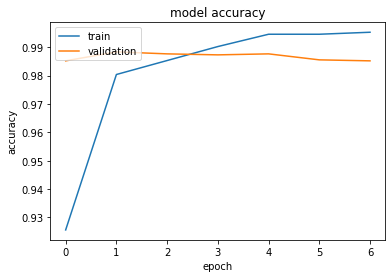

In [20]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Summarize history for loss

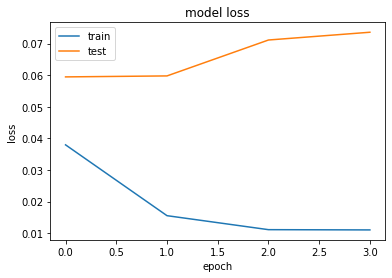

In [42]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Percentage accuracy of model

In [43]:
data_test.shape
labels_pred = model.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 98.94%


precision, and recall scores

In [44]:
print(classification_report(labels_test, labels_pred))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99      2379
          1       0.99      0.94      0.97       462

avg / total       0.99      0.99      0.99      2841

